In [1]:
import numpy as np
from mpl_toolkits import mplot3d
from rom_am import DMD, ROM
import matplotlib.pyplot as plt
import scipy.interpolate as si

In [2]:
Young = ['', '_1_8e7', '_2_4e7', '_3e7', '_4_2e7', '_4_8e7', '_9_6e7']
Young_vals = [1.2e7, 1.8e7, 2.4e7, 3e7, 4.2e7, 4.8e7, 9.6e7]
    
choose = 0
Young = Young[choose]

In [3]:
## ============== FLuid Data =========================
pist_pressure_data = np.load("../DATA/1D_solid_newm_mass_1000_4"+Young+"/pist_pressure_1D.npy")
fl_pressure_data = np.load("../DATA/1D_solid_newm_mass_1000_4"+Young+"/fl_pressure_1D.npy")
fl_rho_e_data = np.load("../DATA/1D_solid_newm_mass_1000_4"+Young+"/fl_rho_e_1D.npy")
fl_rho_v_data = np.load("../DATA/1D_solid_newm_mass_1000_4"+Young+"/fl_rho_v_1D.npy")
fl_velocity_end_data = np.load("../DATA/1D_solid_newm_mass_1000_4"+Young+"/fl_velocity_end_1D.npy")
fl_rho_data = np.load("../DATA/1D_solid_newm_mass_1000_4"+Young+"/fl_rho_1D.npy")
moving_mesh_data = np.load("../DATA/1D_solid_newm_mass_1000_4"+Young+"/moving_mesh_1D.npy")
delta_t_data = np.load("../DATA/1D_solid_newm_mass_1000_4"+Young+"/delta_t_1D.npy")
fl_energy_data = fl_rho_e_data/fl_rho_data
fl_velocity_data = fl_rho_v_data/fl_rho_data
nt_data = delta_t_data.shape[0]

## ============== Solid Data =========================
u_n_data = np.load("../DATA/1D_solid_newm_mass_1000_4"+Young+"/sol_u_t_1D.npy")
u_dt_data = np.load("../DATA/1D_solid_newm_mass_1000_4"+Young+"/sol_u_dt_1D.npy")
u_ddt_data = np.load("../DATA/1D_solid_newm_mass_1000_4"+Young+"/sol_u_ddt_1D.npy")

t_data = np.cumsum(delta_t_data)
nxf = fl_pressure_data.shape[0]
nxs = u_n_data.shape[0]
L = 1
L0 = 1
mass = 1000
Ls0 = 1.2
young = Young_vals[choose]
rho_s = 833.33
solid_T0 = 4 * Ls0 / (np.sqrt(young/rho_s))

**Interpolating on an equally sampled time grid**

In [4]:
# Choose number of equally spaced timesteps 
n_T = 4 # ~ Number of modes in data
n_snap = 421 # Number of snapshots in the train data
frac = 2.22 # ~ Number of time periods in the train data
nt = int(n_snap /(frac/n_T)) # Number of snapshots in the test+train data
dt = (t_data[-1] - t_data[0]) / (nt - 1)

# Interpolating original data to the new timesteps - Fluid
t = np.linspace(t_data[0], t_data[-1], nt)
t0 = t[0]
pist_pressure = si.griddata(t_data, pist_pressure_data.T, t, method='linear').T
pressure = si.griddata(t_data, fl_pressure_data.T, t, method='linear').T
moving_mesh = si.griddata(t_data, moving_mesh_data.T, t, method='linear').T
velocity = si.griddata(t_data, fl_velocity_data.T, t, method='linear').T

# Interpolating original data to the new timesteps - Solid
u_n = si.griddata(t_data, u_n_data.T, t, method='linear').T
u_dt = si.griddata(t_data, u_dt_data.T, t, method='linear').T
u_ddt = si.griddata(t_data, u_ddt_data.T, t, method='linear').T

**Separating training and testing data**

In [5]:
Coeff = frac/n_T

## Training data ============================
train_pressure = pressure[:, :int(Coeff*nt)]
train_velocity = velocity[:, :int(Coeff*nt)]
train_mesh = moving_mesh[:, :int(Coeff*nt)]

train_u_n = u_n[:, :int(Coeff*nt)]
train_u_dt = u_dt[:, :int(Coeff*nt)]
train_u_ddt = u_ddt[:, :int(Coeff*nt)]

train_t = t[:int(Coeff*nt)]

## Testing data ============================
test_pressure = pressure[:, int(Coeff*nt)::]
test_velocity = velocity[:, int(Coeff*nt)::]
test_mesh = moving_mesh[:, int(Coeff*nt)::]

test_u_n = u_n[:, int(Coeff*nt)::]
test_u_dt = u_dt[:, int(Coeff*nt)::]
test_u_ddt = u_ddt[:, int(Coeff*nt)::]

test_t = t[int(Coeff*nt)::]

train_data = np.vstack((train_pressure, train_velocity, train_mesh, train_u_n, train_u_dt, train_u_ddt))
X = train_data[:, :-1]
Y = train_data[:, 1::]

**Now, DMD :**

In [6]:
dmd = DMD()
drom = ROM(dmd)
drom.decompose(X, Y = Y, dt = dt, normalize=True)

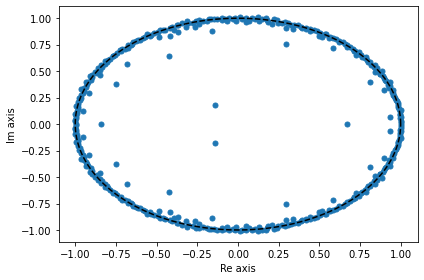

In [7]:
plt.plot(np.real(drom.model.lambd), np.imag(drom.model.lambd), '.', markersize = 10,);
plt.xlabel("Re axis");
plt.ylabel("Im axis");
theta = np.linspace(0, 2*np.pi, 1024)
plt.plot(np.cos(theta), np.sin(theta), "k--");

plt.tight_layout();

## DMD prediction

**Prediction parameters**

In [8]:
fl_node = np.random.randint(1, nxf-1) # Node number - fluid - (visu.)
s_node = np.random.randint(0, nxs-2) # Node number - solid - (visu.)
if fl_node>0:
    node_frac_fl = (fl_node)/nxf
else:
    node_frac_fl = (nxf - fl_node + 1)/nxf
if s_node>=0:
    node_frac_s = (s_node)/nxs
else:
    node_frac_s = (nxs - s_node + 1)/nxs

pred_t = np.concatenate((t, t[:int(.4*nt)]+t[-1])) # Prediction time interval
t1 = t0 # Initial snapshot instant
satbilize_ = True # Eigenvalue shifting (or not)
method = 0 # Method of amplitude computation -- Check the doc

**DMD Prediction**

In [9]:
pred = np.real(drom.predict(pred_t, t1 = t1, stabilize=satbilize_, method = method))

pred_pres = pred[:nxf, :]
pred_veloc = pred[nxf:2*nxf, :]
pred_mesh = pred[2*nxf:3*nxf, :]

pred_u_n = pred[3*nxf:3*nxf+nxs, :]
pred_u_dt = pred[3*nxf+nxs : 3*nxf+2*nxs, :]
pred_u_ddt = pred[3*nxf+2*nxs::, :]

**Plots**

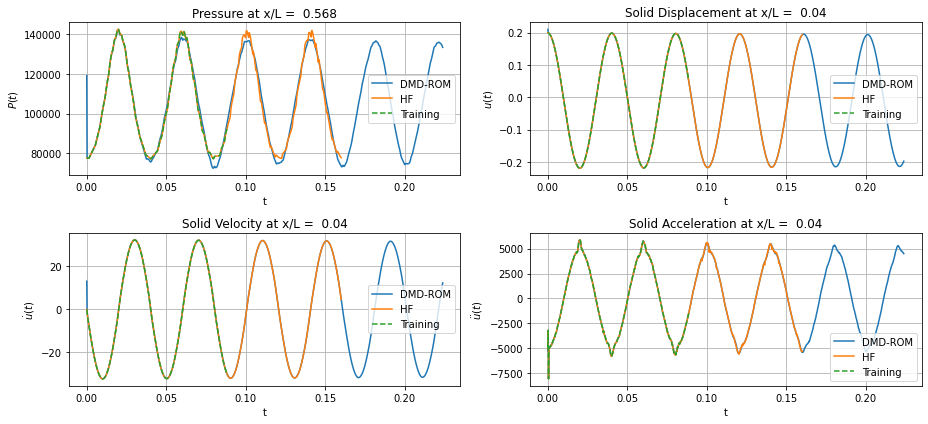

In [10]:
fig, ax = plt.subplots(2, 2, figsize = (13, 6))

ax[0, 0].plot(pred_t, pred_pres[fl_node, :], '-', label = "DMD-ROM")
ax[0, 0].plot(t, pressure[fl_node, :], '-', label = "HF")
ax[0, 0].plot(train_t, train_pressure[fl_node, :], '--', label = "Training")
ax[0, 0].legend();
ax[0, 0].grid();
ax[0, 0].set_xlabel("t");
ax[0, 0].set_ylabel("$P(t)$");
ax[0, 0].set_title("Pressure at x/L =  " + str(node_frac_fl));

ax[0, 1].plot(pred_t, pred_u_n[s_node, :], '-', label = "DMD-ROM")
ax[0, 1].plot(t, u_n[s_node, :], '-', label = "HF")
ax[0, 1].plot(train_t, train_u_n[s_node, :], '--', label = "Training")
ax[0, 1].legend();
ax[0, 1].grid();
ax[0, 1].set_xlabel("t");
ax[0, 1].set_ylabel("$u(t)$");
ax[0, 1].set_title("Solid Displacement at x/L =  " + str(node_frac_s));


ax[1, 0].plot(pred_t, pred_u_dt[s_node, :], '-', label = "DMD-ROM")
ax[1, 0].plot(t, u_dt[s_node, :], '-', label = "HF")
ax[1, 0].plot(train_t, train_u_dt[s_node, :], '--', label = "Training")
ax[1, 0].legend();
ax[1, 0].grid();
ax[1, 0].set_xlabel("t");
ax[1, 0].set_ylabel("$\dotu(t)$");
ax[1, 0].set_title("Solid Velocity at x/L =  " + str(node_frac_s));

ax[1, 1].plot(pred_t, pred_u_ddt[s_node, :], '-', label = "DMD-ROM")
ax[1, 1].plot(t, u_ddt[s_node, :], '-', label = "HF")
ax[1, 1].plot(train_t, train_u_ddt[s_node, :], '--', label = "Training")
ax[1, 1].legend();
ax[1, 1].grid();
ax[1, 1].set_xlabel("t");
ax[1, 1].set_ylabel("$\ddotu(t)$");
ax[1, 1].set_title("Solid Acceleration at x/L =  " + str(node_frac_s));

fig.tight_layout();

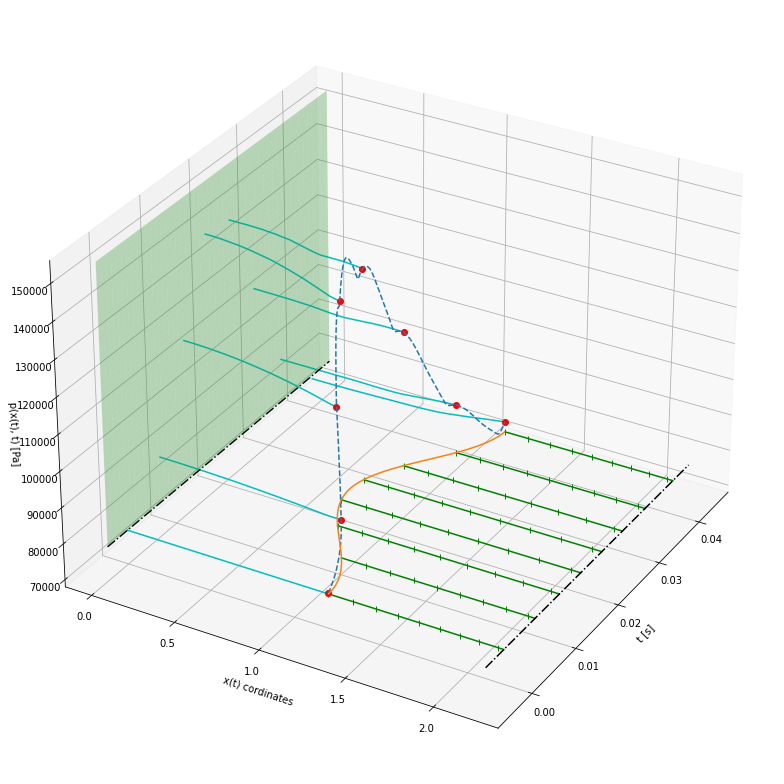

In [11]:
idx = np.argmin(np.abs(t_data - solid_T0))
max_P = 0.

s_coor = np.linspace(0, Ls0, nxs)
fig = plt.figure(figsize = (13, 11))
ax = plt.axes(projection='3d')

coeffs = np.linspace(0, 1, 8)
for coeff in coeffs:
    
    cf = int(coeff * idx)

    zline = fl_pressure_data[:, cf]
    xline = t_data[cf]*np.ones(zline.shape)
    yline = moving_mesh_data[:, cf]

    sl_yline = u_n_data[:, cf] + s_coor + L0
    
    if cf == 0:
        basis = zline.min()
        sl_zline = basis*np.ones(nxs)


    ax.plot3D(xline, sl_yline, sl_zline, 'g-|', markevery = 30)
    ax.plot3D(xline, yline, zline, 'c')
    ax.plot3D(t_data[cf], moving_mesh_data[-1, cf], fl_pressure_data[-1, cf], 'o', color = "red")
    
    max_P = max(max_P, zline.max())


added = .1 * t_data[cf]
ax.plot3D(t_data[:cf], moving_mesh_data[-1, :cf], pist_pressure_data[:cf], '--')
ax.plot3D(t_data[:cf], u_n_data[0, :cf]+1., basis*np.ones(cf))
ax.plot3D([-added, t_data[cf]+added], [2.2, 2.2], [basis, basis], '-.', color = "black")
ax.plot3D([-added, t_data[cf]+added], [0., 0.], [basis, basis], '-.', color = "black")

x = np.linspace(-added, t_data[cf]+added ,100)
z = np.linspace(basis, max_P*1.1, 100)
X,Z = np.meshgrid(x,z)
Y = np.zeros(X.shape)
ax.plot_surface(X, Y, Z, alpha=0.3)


ax.set_zlim(bottom = 0.9 * basis)
ax.invert_xaxis()
ax.view_init(azim=30)
plt.xlabel("t [s]")
plt.ylabel("x(t) cordinates ")
ax.set_zlabel("p(x(t), t) [Pa]")

plt.tight_layout();